# Condições da Tarefa Principal

A operadora de comunicações Interconnect gostaria de ser capaz de predizer a rotatividade de seus clientes. Se for descoberto que um usuário está planejando trocar de operadora, a empresa oferecerá-lhe códigos promocionais e opções de plano especiais. A equipe de marketing da Interconnect coletou alguns dados pessoais da sua clientela, incluindo a informação sobre seus planos e contratos.

### Serviços da Interconnect

A Interconnect fornece principalmente dois tipos de serviços:

1. Telefonia fixa. O telefone pode ser conectado a várias linhas ao mesmo tempo.
2. Internet. A rede pode ser estabelecida através de uma linha telefônica (DSL, *digital subscriber line - linha digital de assinante*) ou através de um cabo de fibra óptica.

Alguns outros serviços fornecidos pela empresa incluem:

- Segurança na Internet: software de antivírus (*DeviceProtection* - proteção de dispositivos) e um bloqueador de sites maliciosos (*OnlineSecurity* - segurança online).
- Uma linha dedicada de suporte técnico (*TechSupport*).
- Armazenamento de arquivos na nuvem e backup de dados (*OnlineBackup*).
- Streaming de TV (*StreamingTV*) e um diretório de filmes (*StreamingMovies*).

Os clientes podem escolher entre fazer um pagamento mensal e assinar um contrato de 1 ou 2 anos. Eles podem usar vários métodos de pagamento e receber uma fatura eletrônica após a transação.

### Descrição dos Dados

Os dados consistem de arquivos obtidos de fontes diferentes:

- `contract.csv` — informação contratual;
- `personal.csv` — dados pessoais do cliente;
- `internet.csv` — informação sobre serviços de Internet;
- `phone.csv` — informação sobre serviços de telefonia.

Em cada arquivo, a coluna `customerID` contém um código unívoco atribuído a cada cliente. A informação contratual é válida a partir de 1 de fevereiro de 2020.

Característica objetivo: a coluna `'EndDate'` é igual a `'No'`.

Métrica primária: AUC-ROC.

Métrica adicional: Acurácia.

Critérios de avaliação:

- AUC-ROC < 0.75 — 0 PPE
- 0.75 ≤ AUC-ROC < 0.81 — 4 PPE
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 PPE
- 0.85 ≤ AUC-ROC < 0.87 — 5 PPE
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 PPE
- AUC-ROC ≥ 0.88 — 6 PPE

# Inicialização

In [1]:
# Bibliotecas padrão
import time
import regex as re
# Manipulação de dados
import pandas as pd
# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
# Modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from pyod.models.knn import KNN
# Pré-processamento de dados
from sklearn.preprocessing import LabelEncoder
# Avaliação de modelos
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, make_scorer
# Divisão e validação dos dados
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# Pré customização dos graficos
plt.rcParams['figure.figsize'] = [14, 5] # Tamanho padrão da figura
plt.rcParams['font.size'] = 12 # Tamanho padrão da fonte

# Paleta de cores com degradê de até 10 cores
colors = sns.color_palette("coolwarm", 10)
sns.set_palette(colors)
plt.style.use('ggplot')

# Fonte da legenda e títulos dos eixos mais clara
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

plt.rcParams['legend.fontsize'] = 12 # Tamanho da legenda
plt.rcParams['lines.linewidth'] = 2

# Alterar largura das linhas para torná-las mais visíveis
plt.rcParams['lines.linewidth'] = 2

# Recebendo os dados

In [3]:
df_contract  = pd.read_csv("final_provider/contract.csv")
df_personal = pd.read_csv("final_provider/personal.csv")
df_internet = pd.read_csv("final_provider/internet.csv")
df_phone = pd.read_csv("final_provider/phone.csv")

# Ferramentas

In [4]:
def identify_anomaly(column, result_view=False, weight=0.25):
    """ Retorna o calculo de anormalidades a partir dos quartis (Q1, Q3) """
    column = column.dropna()  # remove nulls se ainda tiver
    if column.dtypes == 'int64' or column.dtypes == 'int32' or column.dtypes == 'float':  # filtra só por numéricos
        plt.figure()  # cria uma nova figura para o gráfico
        boxplot = plt.boxplot(column.values)
        plt.title(f"Boxplot da coluna {column.name}")
        
        outliers = list(boxplot['fliers'][0].get_data()[1])
        print(f'Valores atípicos na coluna {column.name}:', len(outliers))
        
        min_val = column.min()
        max_val = column.max()
        Q1 = column.quantile(weight)
        Q3 = column.quantile(1-weight)
        IQR = Q3 - Q1 
        Q1 = Q1 - 1.5 * IQR    
        Q3 = Q3 + 1.5 * IQR

        if result_view:
            print(f"Coluna: {column.name}")
            print(f"\033[91m Menor {min_val}, Anormal: {Q1} \033[30m") if min_val < Q1 else print(f"\033[32m Menor {min_val}, Anormal: {Q1} \033[30m") 
            print(f"\033[91m Maior {max_val}, Anormal: {Q3} \033[30m") if max_val > Q3 else print(f"\033[32m Maior {max_val}, Anormal: {Q3} \033[30m") 
            print(f"IQR: {IQR}")
            print()
            if min_val > Q1 and max_val < Q3:
                return None
        return Q1, Q3
    
    else:
        if result_view:
            print(column.name, "Não é numérico")
        return None

In [5]:
def clean_over(dataframe, weight=0.25, show_results=False):
    """ Cria uma query para remover todos os anormais de todas colunas do dataframe """
    query = ""
    for column in dataframe.columns:
        result = identify_anomaly(dataframe[column].dropna(), show_results, weight=weight)

        # Verificar se o resultado não é None (none != numeric)
        if result is not None:
            min, max = result # pega o minimo e o maximo da coluna
            query += f'({min} < `{column}`) and ( `{column}` < {max} ) and '

    return query[:-4]

In [6]:
def name_reformat(text):
    """ reparo individual """
    
    new_text = re.sub(r'([a-z])([A-Z])', r'\1_\2', text).lower()

    return new_text[0].lstrip('_') + new_text[1:]
def list_name_reformat(names):
    """ reparo de lista """
    new_names = []
    for name in names:
        new_names.append(name_reformat(name))
    return new_names


In [7]:
class Metodo_avaliativo:
    def __init__(self):
        self.ranking_model = {}
        self.target_score = 75

    def add_model(self, model, target_test, features_test, time_lapse=0):
        """
        Adiciona um modelo ao ranking e calcula as métricas: ROC AUC, F1-Score, e Acurácia.
        :param model_name: Nome do modelo
        :param target_test: Valores reais do conjunto de teste
        :param predictions: Previsões feitas pelo modelo
        :param time_lapse: Tempo de execução do modelo
        :param proba_predictions: Probabilidades previstas (necessárias para calcular o ROC AUC)
        """
        model_name = type(model).__name__
        predictions = model.predict(features_test)
        try:
            proba_predictions = model.predict_proba(features_test)[:, 1]
        except:
            proba_predictions = None
        # Calcular as métricas principais
        accuracy = accuracy_score(target_test, predictions)
        f1 = f1_score(target_test, predictions)
        
        # Verificar se as probabilidades foram fornecidas para calcular ROC AUC
        roc_auc = None
        if proba_predictions is not None:
            roc_auc = roc_auc_score(target_test, proba_predictions)

        # Exibir as métricas
        print(f" Acurácia: {accuracy}")
        print(f" F1-Score: {f1}")
        if roc_auc is not None:
            print(f" ROC AUC: {roc_auc}")
        print(f"Tempo total de execução: {time_lapse:.2f} segundos")
        
        # Armazenar as métricas no ranking
        self.ranking_model[model_name] = [accuracy, f1, roc_auc, time_lapse]
        
        # Plotar as métricas em gráficos da curva ROC e matriz de confusão
        self.plot_metrics_roc_confusion_matrix(model_name, accuracy, f1, roc_auc, target_test, predictions, proba_predictions)
        
    def get_ranking(self, sort_by="ROC_AUC", ascending=False):
        """
        Retorna um DataFrame com o ranking dos modelos de acordo com a métrica especificada.
        :param sort_by: Métrica pela qual o ranking será ordenado (ex: Acurácia, F1-Score, ROC AUC)
        :param ascending: Ordenar de forma ascendente ou descendente
        :return: DataFrame com o ranking dos modelos
        """
        df = (pd.DataFrame(self.ranking_model, index=['Acurácia', "F1-Score", "ROC_AUC", "Tempo_de_execução"])).T
        return df.sort_values(ascending=ascending, by=sort_by)

    def plot_metrics_roc_confusion_matrix(self, model_name, accuracy, f1, roc_auc, target_test, predictions, proba_predictions):
        """
        Plota as métricas de Acurácia, F1-Score e ROC AUC, juntamente com a curva ROC e a matriz de confusão.
        :param model_name: Nome do modelo
        :param accuracy: Acurácia do modelo
        :param f1: F1-Score do modelo
        :param roc_auc: ROC AUC do modelo
        :param target_test: Valores reais do conjunto de teste
        :param predictions: Previsões feitas pelo modelo
        :param proba_predictions: Probabilidades previstas pelo modelo
        """
        metrics = ['Acurácia', 'F1-Score', 'ROC AUC']
        values = [accuracy, f1, roc_auc if roc_auc is not None else 0]

        # Gráfico de métricas, Curva ROC, Matriz de Confusão
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Subplot 1: Gráficos de barra para Acurácia, F1-Score, ROC AUC
        axes[0].bar(metrics, values, color=['blue', 'green', 'orange'])
        axes[0].set_title(f'Métricas - {model_name}')
        axes[0].set_ylim(0, 1)
        axes[0].set_ylabel('Valor')

        # Subplot 2: Curva ROC
        if proba_predictions is not None:
            fpr, tpr, _ = roc_curve(target_test, proba_predictions)
            axes[1].plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
            axes[1].plot([0, 1], [0, 1], color='red', linestyle='--')
            axes[1].set_xlim([0.0, 1.0])
            axes[1].set_ylim([0.0, 1.05])
            axes[1].set_xlabel('False Positive Rate')
            axes[1].set_ylabel('True Positive Rate')
            axes[1].set_title(f'Curva ROC - {model_name}')
            axes[1].legend(loc="lower right")
            axes[1].grid(True)

        # Subplot 3: Matriz de Confusão
        conf_matrix = confusion_matrix(target_test, predictions)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[2])
        axes[2].set_title(f'Matriz de Confusão - {model_name}')
        axes[2].set_xlabel('Predito')
        axes[2].set_ylabel('Real')
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()


ranking = Metodo_avaliativo()

# EAP

## Dados em Contract

In [8]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Primeira impressão, já possuimos uma coluna com dados boleanos e datetime

In [9]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Quase tudo como object, totalCharges deverá estar como float

In [10]:
df_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


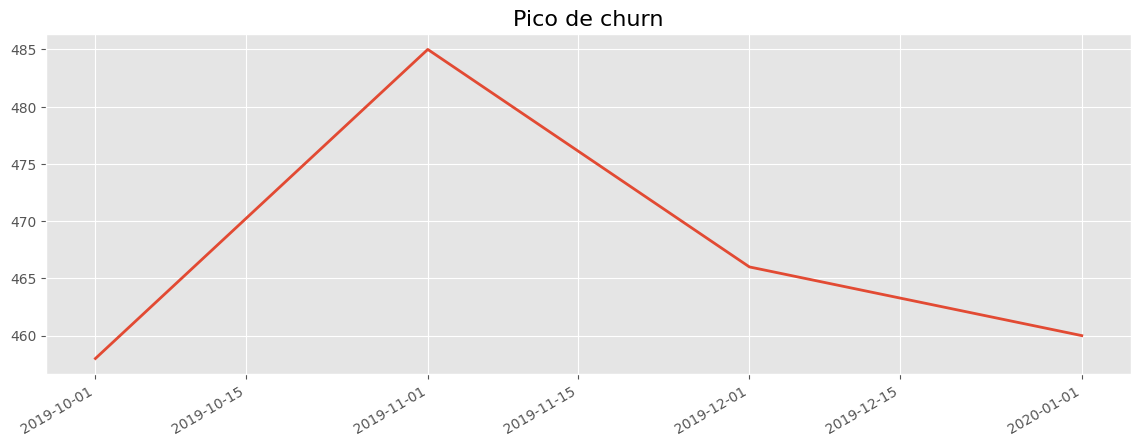

In [11]:
# analise do maior pico "churn"
pd.to_datetime(df_contract.query('EndDate != "No"')['EndDate'], format='%Y-%m-%d').value_counts().plot()
plt.title("Pico de churn")
plt.show()

## Personal DF

In [12]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [13]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


mais colunas dispostas em object envez de int ou boolean, contudo não mudarei pois pretendo converte-las em classificação

In [14]:
df_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


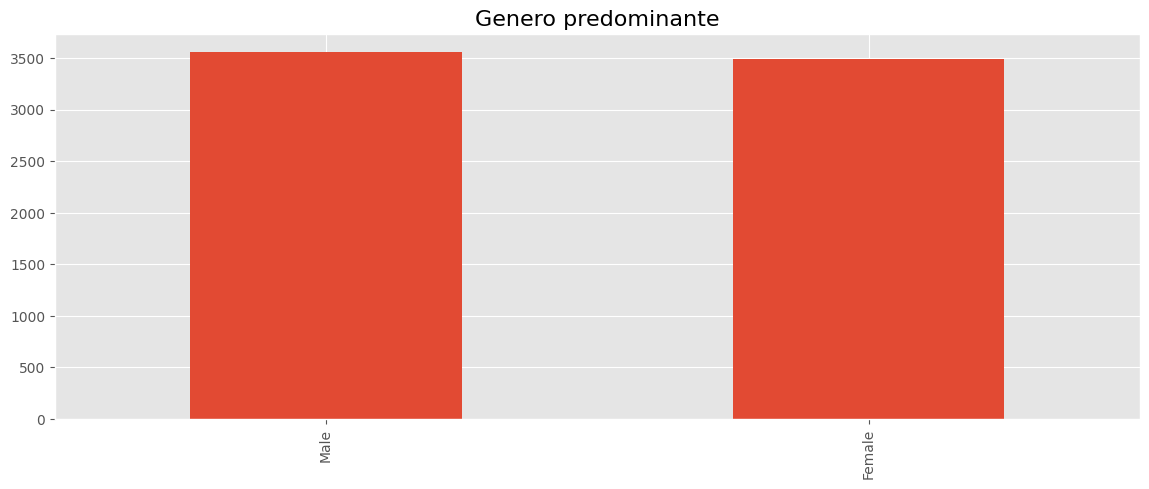

In [15]:
df_personal['gender'].value_counts().plot(kind='bar')
plt.title("Genero predominante")
plt.show()

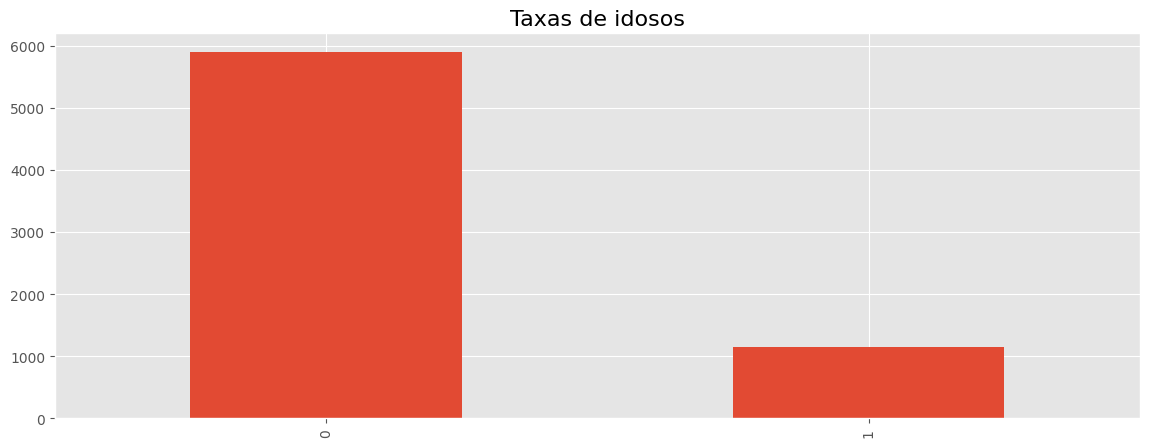

In [16]:
df_personal['SeniorCitizen'].value_counts().plot(kind='bar')
plt.title('Taxas de idosos')
plt.show()

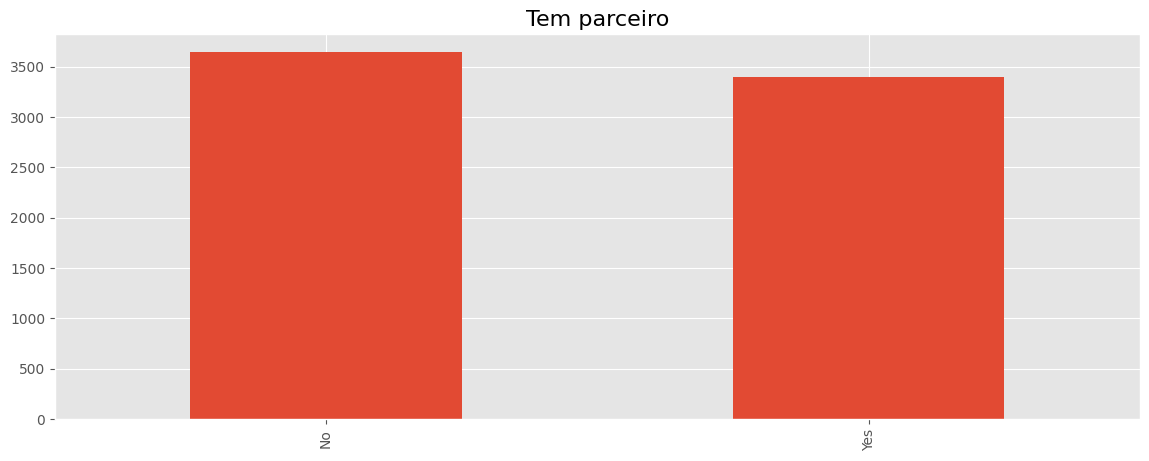

In [17]:
df_personal['Partner'].value_counts().plot(kind='bar')
plt.title('Tem parceiro')
plt.show()

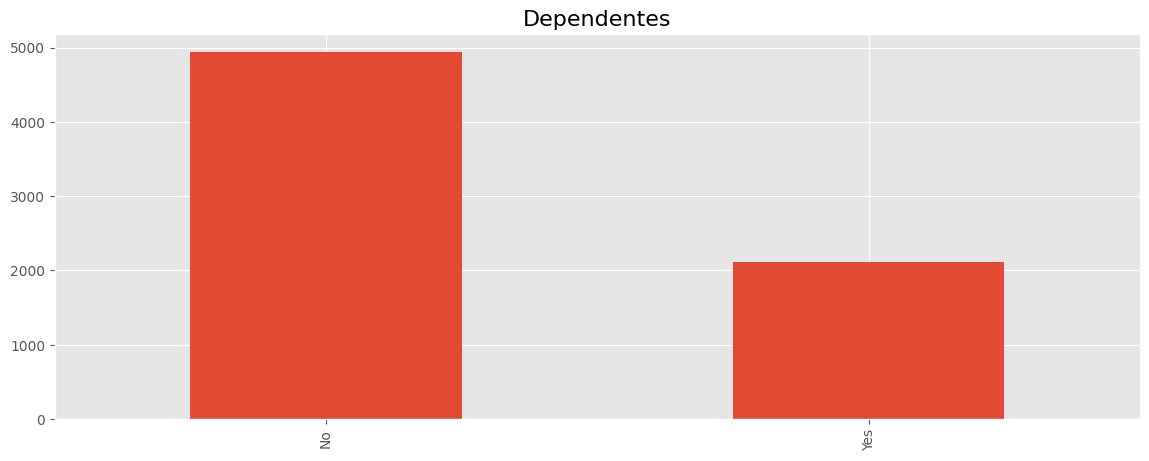

In [18]:
df_personal['Dependents'].value_counts().plot(kind='bar')
plt.title("Dependentes")
plt.show()

A Maioria dos clientes não possuem dependentes

## Internet DF

In [19]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [20]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


varios dados booleanos estão como strings

In [21]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


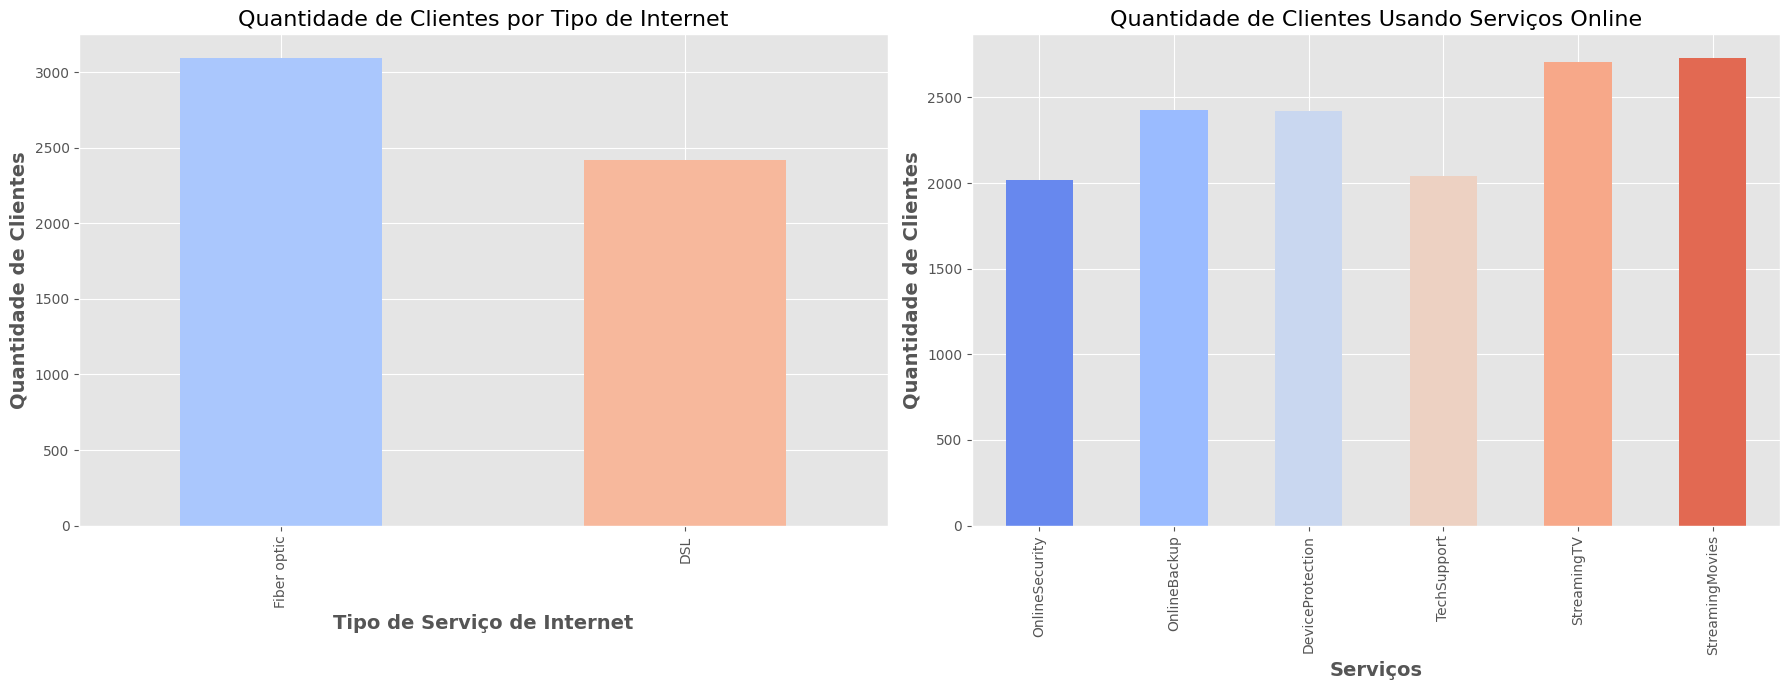

In [22]:
# Configurar o layout com dois gráficos lado a lado (esquerda e direita)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Contagem de tipos de InternetService
internet_service_counts = df_internet['InternetService'].value_counts()
internet_service_counts.plot(kind='bar', ax=axes[0], color=sns.color_palette("coolwarm", 2))
axes[0].set_title('Quantidade de Clientes por Tipo de Internet', fontsize=16)
axes[0].set_xlabel('Tipo de Serviço de Internet', fontsize=14)
axes[0].set_ylabel('Quantidade de Clientes', fontsize=14)

# Gráfico 2: Contagem de serviços online
service_counts = df_internet.drop(['customerID','InternetService'], axis=1).apply(lambda x: x.value_counts().get('Yes', 0))
service_counts.plot(kind='bar', ax=axes[1], color=sns.color_palette("coolwarm", len(service_counts)))
axes[1].set_title('Quantidade de Clientes Usando Serviços Online', fontsize=16)
axes[1].set_xlabel('Serviços', fontsize=14)
axes[1].set_ylabel('Quantidade de Clientes', fontsize=14)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

Uma grande quantidade de usuarios são favoraveis aos streamings e intenet de fibra otica

## Phone DF

In [23]:
# preview dos dados
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [24]:
# formato dos dados
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


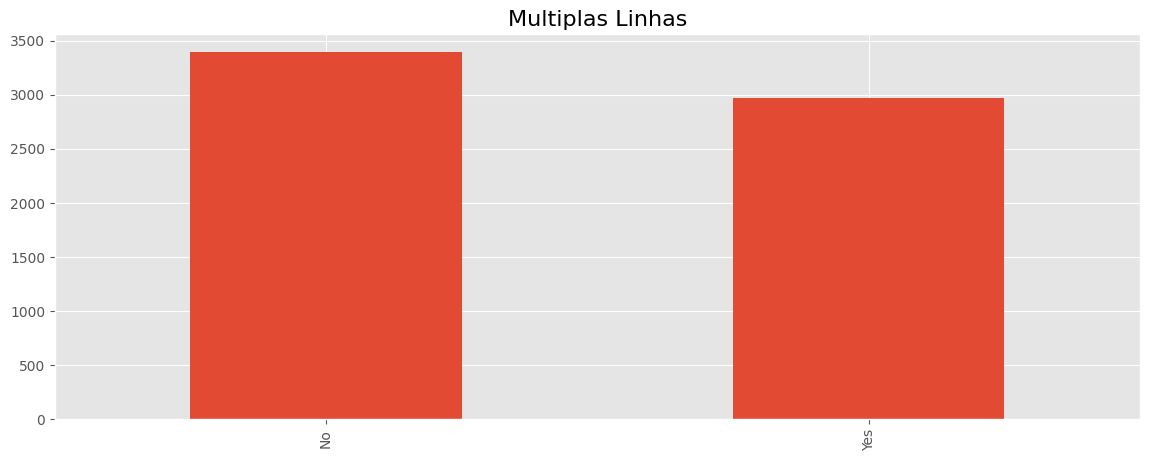

In [25]:
df_phone['MultipleLines'].value_counts().plot(kind='bar')
plt.title("Multiplas Linhas")
plt.show()

boa parte dos clientes não usam mais de uma linha

# DF merged

In [26]:
df_result = pd.merge(df_contract, df_personal, on='customerID', how='inner')
df_result = pd.merge(df_result, df_internet, on='customerID', how='outer')
df_result = pd.merge(df_result, df_phone, on='customerID', how='outer')


In [27]:
# renomeia as colunas para melhor leitura
df_result.columns = list_name_reformat(df_result.columns)

In [28]:
# result
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

## tratamento dos dados em conjunto

In [29]:
# coluna datetime
df_result['begin_date'] = pd.to_datetime(df_result['begin_date'], format='%Y-%m-%d')

In [30]:
# vou manter a coluna como objetct porem com valores boleanos, pois categorizarei posteriormente
df_result.loc[df_result['end_date'] != "No", 'end_date'] = "Yes"

In [31]:
# vou renomear a coluna de end_date para churn pois não há mais datas nessa coluna
df_result.rename({'end_date':'churn'}, axis=1, inplace=True)

In [32]:
# converter a coluna total_charges para float, porem ela possuia espaços que precisaram ser removidos
df_result['total_charges'] = df_result['total_charges'].apply(lambda text : "0" if text == " " else text).astype('float')

Valores atípicos na coluna monthly_charges: 0
Coluna: monthly_charges
 Menor 18.25, Anormal: -46.02499999999999 
 Maior 118.75, Anormal: 171.375 
IQR: 54.349999999999994

Valores atípicos na coluna total_charges: 0
Coluna: total_charges
 Menor 0.0, Anormal: -4683.525 
 Maior 8684.8, Anormal: 8868.675 
IQR: 3388.0499999999997



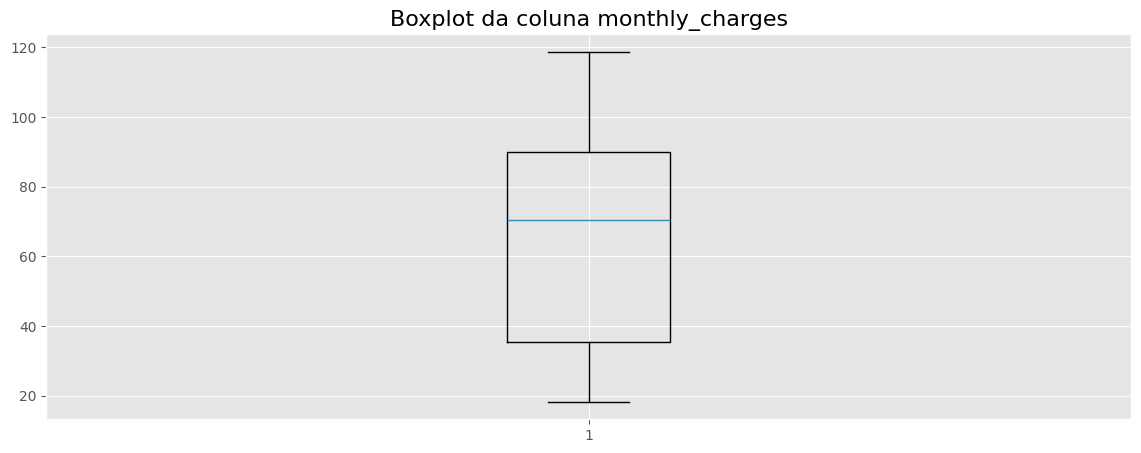

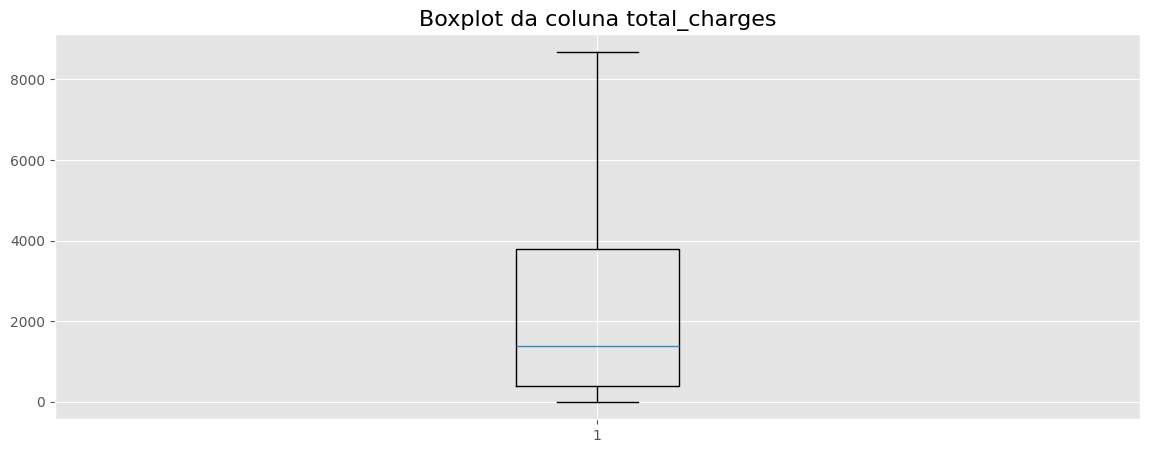

In [33]:
query_set = clean_over(df_result[['monthly_charges','total_charges']], weight=0.25, show_results=True)

como o menor total esta menor que a de recargas mensais?

In [34]:
df_result.query('total_charges < monthly_charges')

,customer_id,begin_date,churn,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Aparentemente não foi contabilizado o total daqueles que sairam no ultimo mes da extração dos dados.

In [35]:
df_result.loc[df_result['total_charges'] == 0, 'total_charges'] = df_result['monthly_charges']

In [36]:
# como parece uma falha vou remover esses volores
df_result = df_result.query('total_charges > monthly_charges').copy()
df_result.shape

(6419, 20)

In [37]:
# from warnings import simplefilter
# # ignore all future warnings
# simplefilter(action='ignore', category=FutureWarning)
# data = df_result[['monthly_charges','total_charges']]
# model = KNN()
# estimation_knn = model.fit_predict(data) == 1
# outliers_knn = estimation_knn.sum()
# print('Número de anomalias (KNN):', outliers_knn)

# model = IsolationForest(n_estimators=100)
# estimation_iforest = model.fit_predict(data) == -1
# outliers_iforest = estimation_iforest.sum()
# print('Número de anomalias (floresta de isolamento):', outliers_iforest)
# result_over = estimation_knn & estimation_iforest
# print('Correspondências:', (result_over).sum())

# # remover os outliers
# df_result = df_result[~result_over].copy()

Limpando onde ficou `N/A`

In [38]:
df_result['internet_service'].fillna('No Plan', inplace=True)

In [39]:
df_result['online_security'].fillna('No Plan', inplace=True)

In [40]:
df_result['online_backup'].fillna('No Plan', inplace=True)

In [41]:
df_result['device_protection'].fillna('No Plan', inplace=True)

In [42]:
df_result['tech_support'].fillna('No Plan', inplace=True)

In [43]:
df_result['streaming_tv'].fillna('No Plan', inplace=True)

In [44]:
df_result['streaming_movies'].fillna('No Plan', inplace=True)

In [45]:
df_result['multiple_lines'].fillna('No Plan', inplace=True)

In [46]:
# analise das strings pra ter certeza que não há anomalias
for col in df_result.columns[1:]:
    if df_result[col].dtype == 'object':  # Apenas para colunas categóricas
        print("uniques from",col,df_result[col].unique(),'\n')

uniques from churn ['No' 'Yes'] 

uniques from type ['One year' 'Month-to-month' 'Two year'] 

uniques from paperless_billing ['No' 'Yes'] 

uniques from payment_method ['Mailed check' 'Bank transfer (automatic)' 'Electronic check'
 'Credit card (automatic)'] 

uniques from gender ['Male' 'Female'] 

uniques from partner ['No' 'Yes'] 

uniques from dependents ['No' 'Yes'] 

uniques from internet_service ['DSL' 'Fiber optic' 'No Plan'] 

uniques from online_security ['Yes' 'No' 'No Plan'] 

uniques from online_backup ['No' 'Yes' 'No Plan'] 

uniques from device_protection ['Yes' 'No' 'No Plan'] 

uniques from tech_support ['No' 'Yes' 'No Plan'] 

uniques from streaming_tv ['No' 'Yes' 'No Plan'] 

uniques from streaming_movies ['No' 'Yes' 'No Plan'] 

uniques from multiple_lines ['No' 'No Plan' 'Yes'] 



In [47]:
# result do result
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6419 entries, 1 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        6419 non-null   object        
 1   begin_date         6419 non-null   datetime64[ns]
 2   churn              6419 non-null   object        
 3   type               6419 non-null   object        
 4   paperless_billing  6419 non-null   object        
 5   payment_method     6419 non-null   object        
 6   monthly_charges    6419 non-null   float64       
 7   total_charges      6419 non-null   float64       
 8   gender             6419 non-null   object        
 9   senior_citizen     6419 non-null   int64         
 10  partner            6419 non-null   object        
 11  dependents         6419 non-null   object        
 12  internet_service   6419 non-null   object        
 13  online_security    6419 non-null   object        
 14  online_b

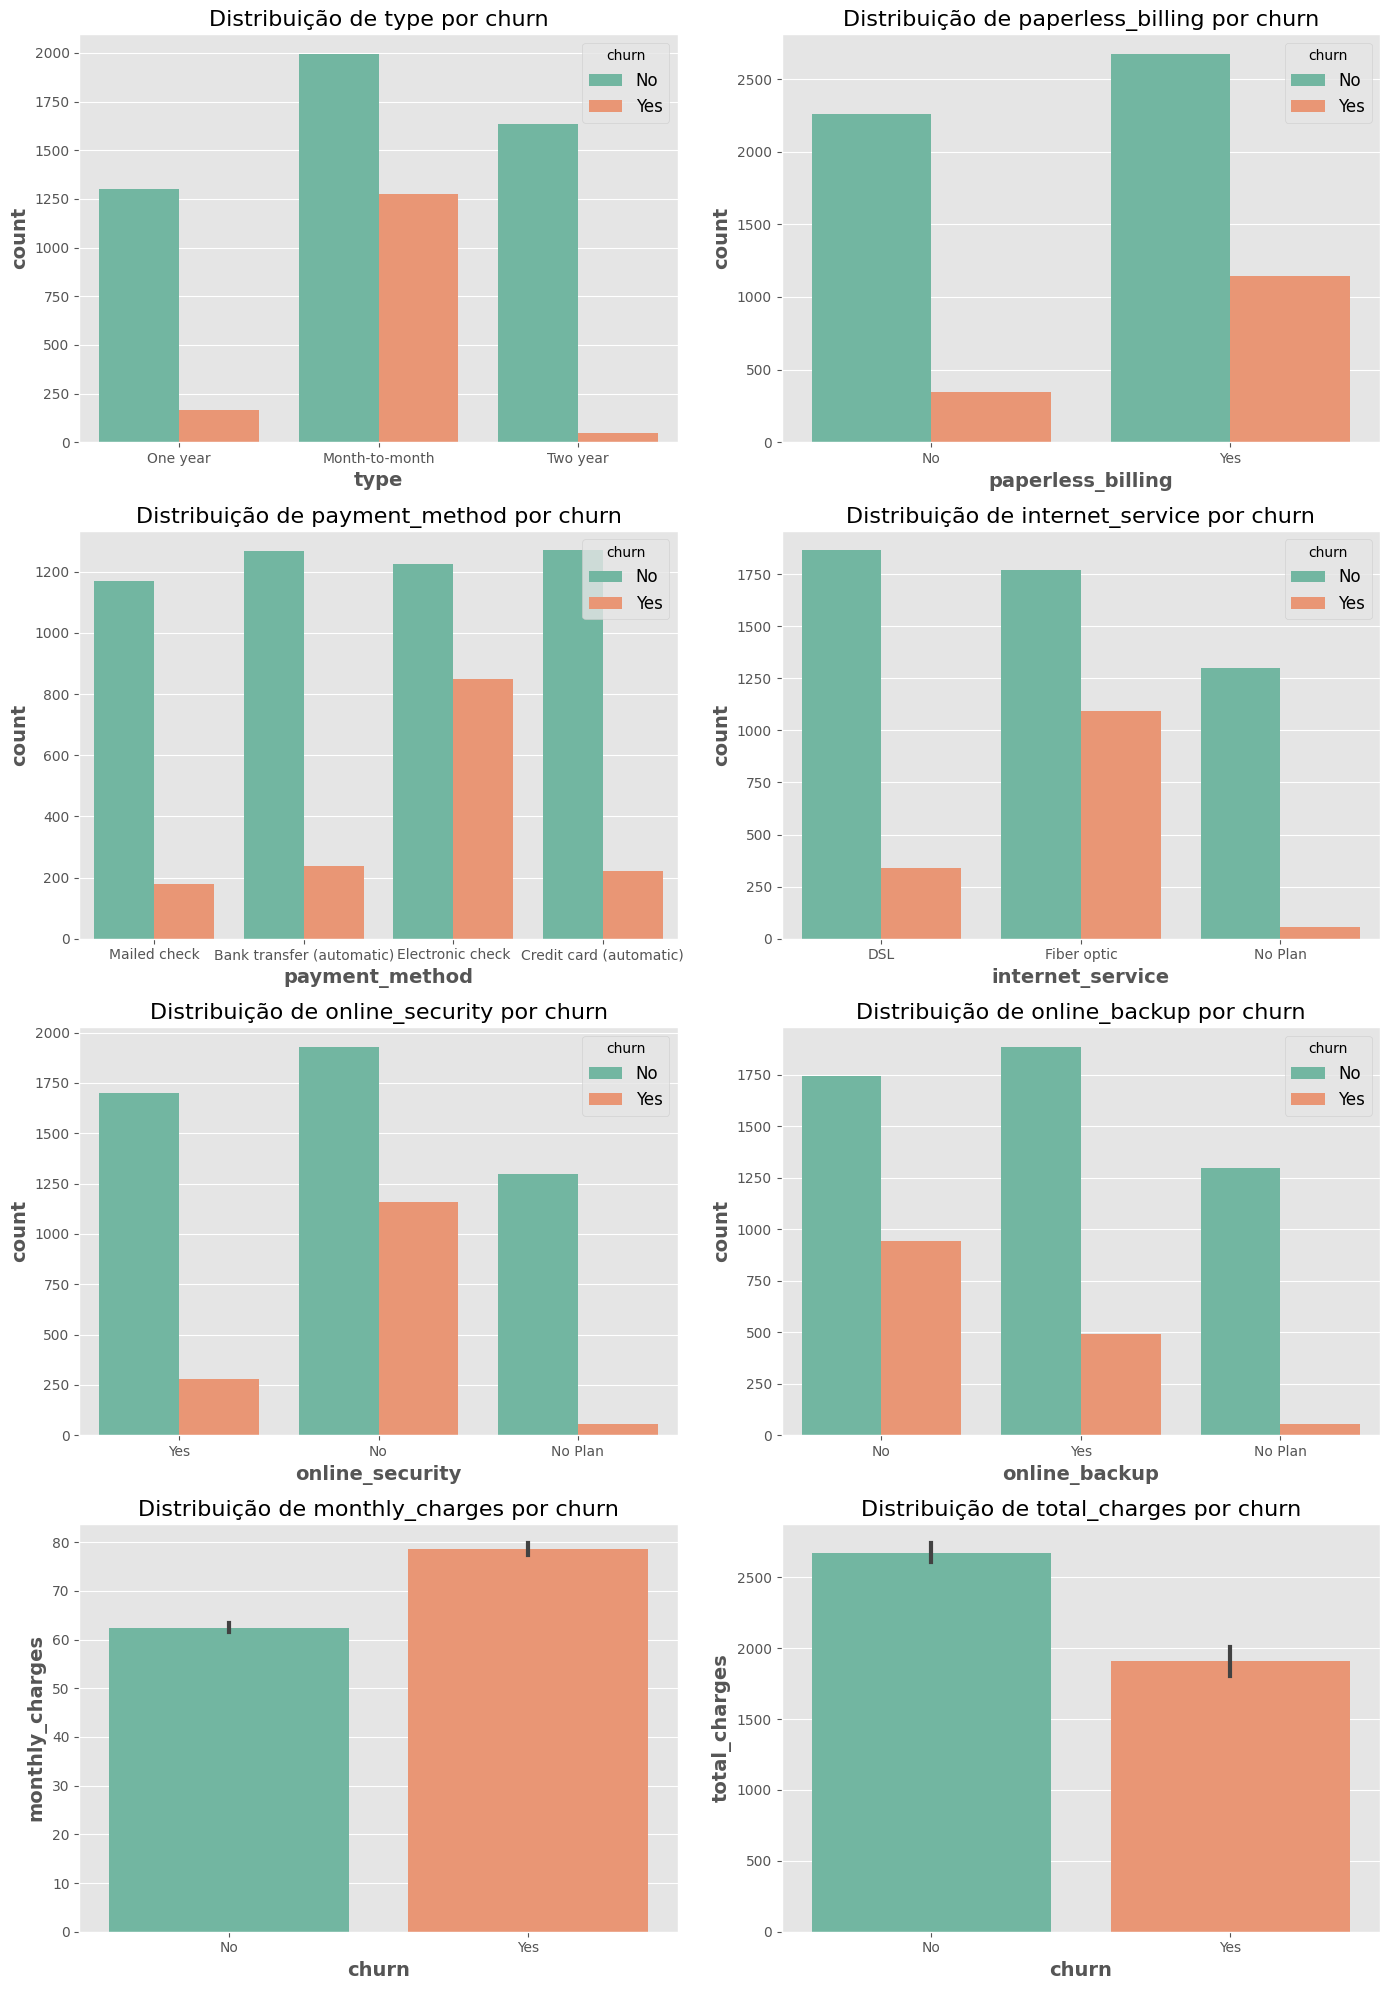

In [48]:
# Visualização das variáveis categóricas por churn
categorical_columns = ['type', 'paperless_billing', 'payment_method', 'internet_service', 
                       'online_security', 'online_backup','monthly_charges', 'total_charges']

# Criar gráficos de barras para as variáveis categóricas
plt.figure(figsize=(14, 20))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(4, 2, i)
    if col in ['monthly_charges', 'total_charges']:
        sns.barplot(data=df_result, x='churn', y=col, hue='churn', estimator='mean', palette='Set2', legend=False)
    else:
        sns.countplot(data=df_result, x=col, hue='churn',palette='Set2')
    plt.title(f'Distribuição de {col} por churn')

plt.tight_layout()
plt.show()


Uma escolha comum dos clientes desistentes são os planos mensais pagos via check eletronico, usuarios de fibra ótica sem segurança online e nem backup



## Categorização dos dados para treino de maquina

In [49]:
label_encoder = LabelEncoder()

encoders = {}

# Aplicar LabelEncoder e armazenar os encoders
for col in df_result.columns[1:]:
    if df_result[col].dtype == 'object':  # Apenas para colunas categóricas
        le = LabelEncoder()
        df_result[col] = le.fit_transform(df_result[col])
        encoders[col] = le  # Armazenar o encoder para cada coluna

In [50]:
df_result.head(4)

,customer_id,begin_date,churn,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
1,5575-GNVDE,2017-04-01,0,1,0,3,56.95,1889.50,1,0,0,0,0,2,0,2,0,0,0,0
2,3668-QPYBK,2019-10-01,1,0,1,3,53.85,108.15,1,0,0,0,0,2,2,0,0,0,0,0
3,7795-CFOCW,2016-05-01,0,1,0,0,42.30,1840.75,1,0,0,0,0,2,0,2,2,0,0,1
4,9237-HQITU,2019-09-01,1,0,1,2,70.70,151.65,0,0,0,0,1,0,0,0,0,0,0,0


# Analise do "churn"

In [51]:
df_churned = df_result.query('churn == False')
print(f'Temos {round(df_churned.shape[0] * 100 / df_result.shape[0])}% dos perfis de clientes que não desistiram, sendo {100-round(df_churned.shape[0] * 100 / df_result.shape[0])}% a taxa de churn.')

Temos 77% dos perfis de clientes que não desistiram, sendo 23% a taxa de churn.


In [52]:
df_churned.head()

,customer_id,begin_date,churn,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
1,5575-GNVDE,2017-04-01,0,1,0,3,56.95,1889.50,1,0,0,0,0,2,0,2,0,0,0,0
3,7795-CFOCW,2016-05-01,0,1,0,0,42.30,1840.75,1,0,0,0,0,2,0,2,2,0,0,1
6,1452-KIOVK,2018-04-01,0,0,1,1,89.10,1949.40,1,0,0,1,1,0,2,0,0,2,0,2
7,6713-OKOMC,2019-04-01,0,0,0,3,29.75,301.90,0,0,0,0,0,2,0,0,0,0,0,1
9,6388-TABGU,2014-12-01,0,1,0,0,56.15,3487.95,1,0,0,1,0,2,2,0,0,0,0,0


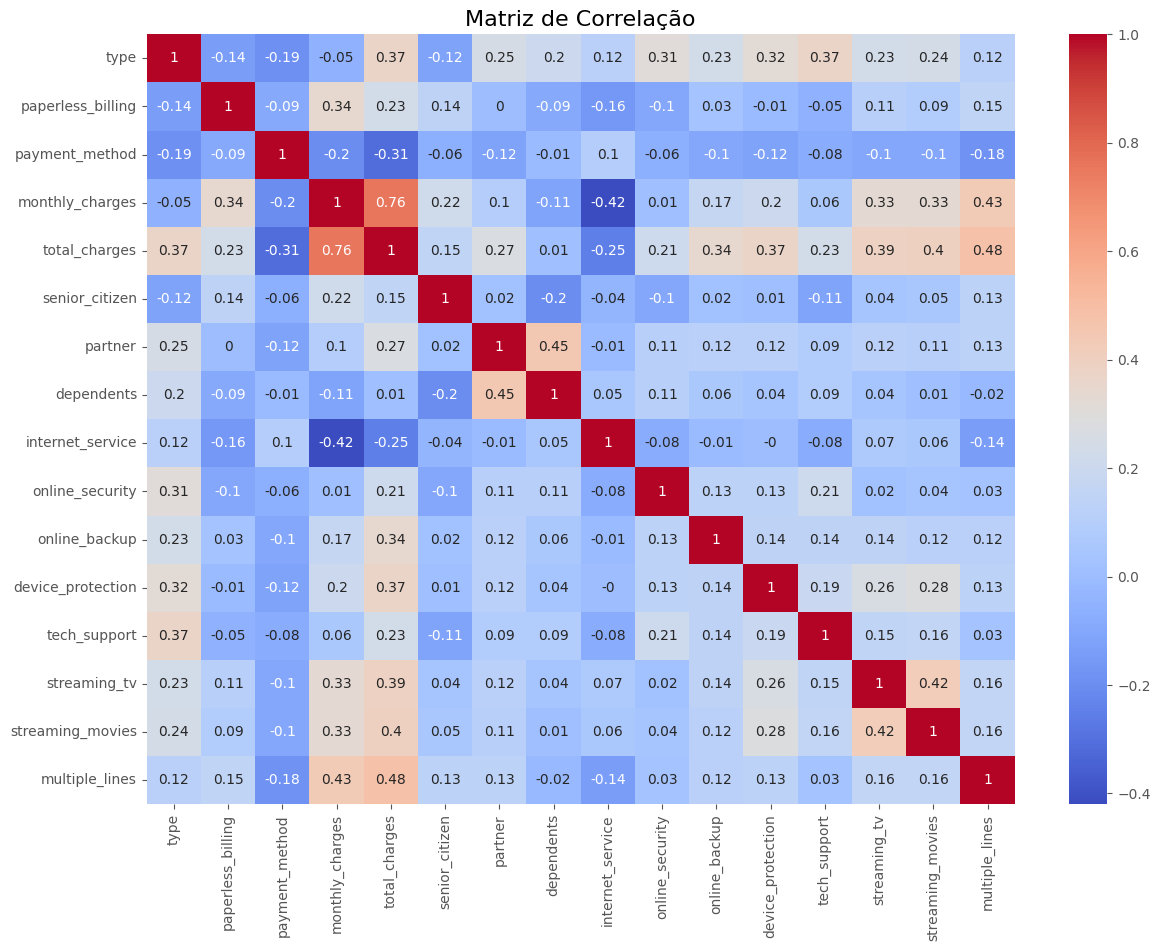

In [53]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_churned.drop(['customer_id','begin_date','gender','churn'], axis=1).corr(numeric_only=True).round(2), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


a maior é a correlação entre recargas mensais e total de recargas, fora isso a mais alta são as recargas com multilplas linhas e streamings, mas tambem importante há uma correlação entre os serviços de internet e os pagamentos mensais.

# Previsões

In [54]:
df_predictions = pd.DataFrame()
df_predictions['target'] = df_result['churn']

In [55]:
df = df_result.drop(['customer_id','gender','begin_date'], axis=1) # removendo a coluna de gender tambem pois ela possuiu pouca correlação com qualquer dado

features, test = train_test_split(df, random_state=12, test_size=0.25)
features_train=features.drop('churn',axis=1)
target_train=features['churn']

features_test=test.drop('churn',axis=1)
target_test=test['churn']


### RandomForestClassifier 

Melhores hiperparâmetros encontrados: {'bootstrap': True, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 2, 'n_estimators': 120}
 Acurácia: 0.8137071651090343
 F1-Score: 0.5291338582677165
 ROC AUC: 0.8553691246987294
Tempo total de execução: 23.80 segundos


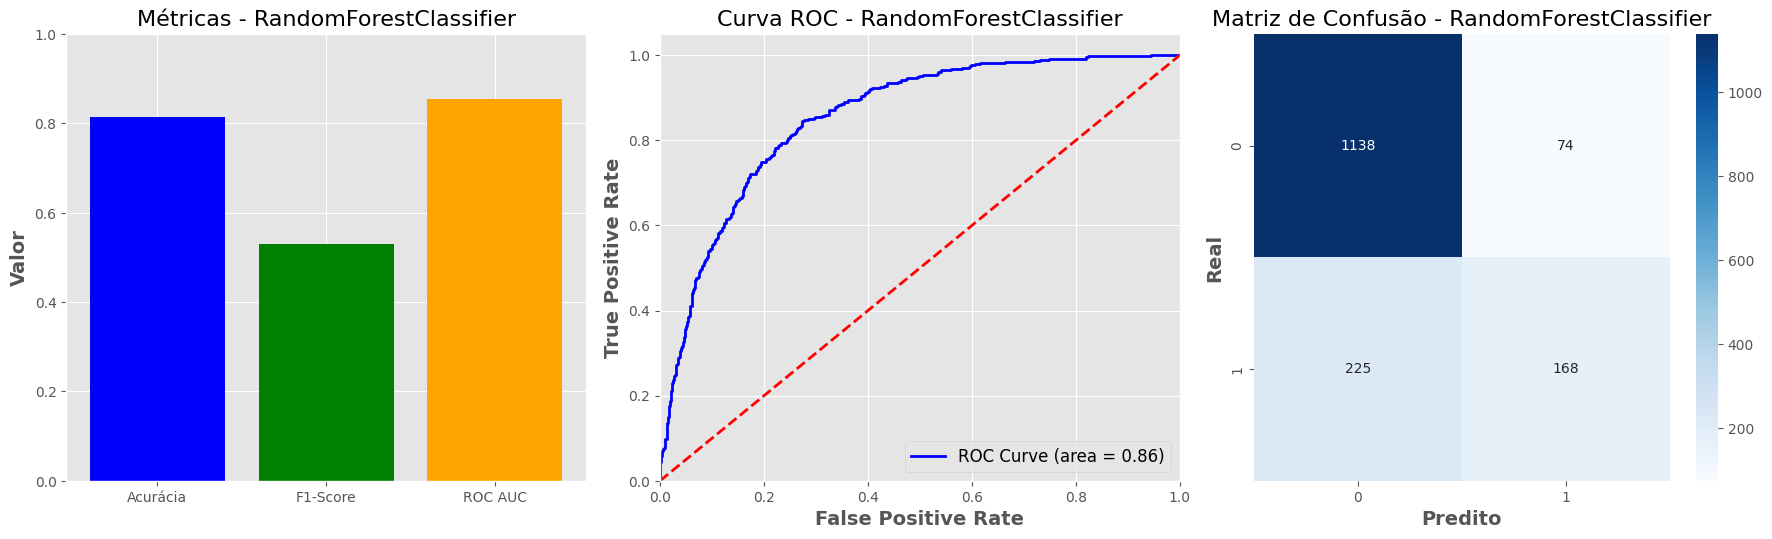

In [56]:
# grid de hiperparâmetros para buscar
param_grid = {
    'n_estimators': [110,120,140],
    'max_depth': [5,9, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [12, 14,16,18],
    'max_features': ['sqrt', ],
    'bootstrap': [True, ]
}

# Inicializar o modelo RandomForestClassifier
rfc = RandomForestClassifier(random_state=12345)

# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='roc_auc', cv=7, n_jobs=-1, verbose=0)

# tempo de início
start_time = time.time()

# Realizar o treinamento com GridSearchCV
grid_search.fit(features_train, target_train)

# Calcular o tempo total de execução
end_time = time.time()
time_lapse = end_time - start_time

best_model = grid_search.best_estimator_ # Melhor modelo obtido

print(f"Melhores hiperparâmetros encontrados: {grid_search.best_params_}")

# Adicionar o melhor modelo ao ranking
ranking.add_model(best_model, target_test, features_test, time_lapse=time_lapse)
# Prever usando o melhor modelo
df_predictions['RDC'] = best_model.predict(df.drop('churn', axis=1))

### DecisionTreeClassifier

Fitting 2 folds for each of 1008 candidates, totalling 2016 fits
Melhores hiperparâmetros encontrados: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 28, 'min_samples_split': 2, 'splitter': 'best'}
 Acurácia: 0.7925233644859813
 F1-Score: 0.5355648535564853
 ROC AUC: 0.8270223968961781
Tempo total de execução: 2.03 segundos


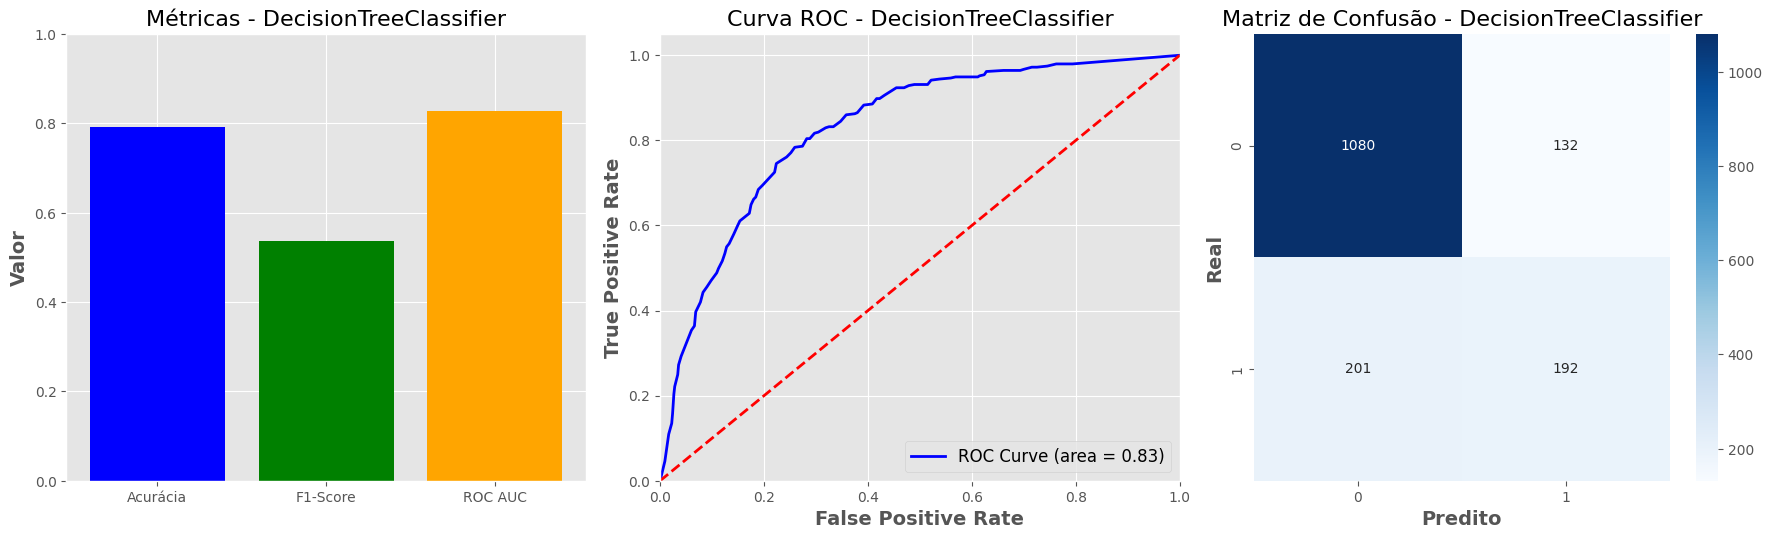

In [57]:
# Tempo de início
start_time = time.time()

# Grid de hiperparâmetros para DecisionTreeClassifier
param_grid = {
    'max_depth': [None,5, 10, 20],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [ 18, 22,24,25,26,27,28],  # Número mínimo de amostras em um nó folha
    'max_features': [None, 'sqrt', 'log2'],  # Número de recursos a serem considerados ao procurar o melhor split
    'criterion': ['gini', 'entropy'],  # Função para medir a qualidade da divisão
    'splitter': ['best', 'random']  # Estratégia usada para escolher a divisão no nó
}
# Inicializar o modelo
dtc = DecisionTreeClassifier(random_state=42)

# Configurar o e treinar o modelo usando o GridSearchCV pra variar os testes
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, scoring='roc_auc', cv=2, n_jobs=-1, verbose=1).fit(features_train, target_train)

# Calcular o tempo total de execução
end_time = time.time()
time_lapse = end_time - start_time

# Melhor modelo obtido
best_model = grid_search.best_estimator_
# Previsões com o melhor modelo
best_predictions = best_model.predict(features_test)
# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros encontrados: {grid_search.best_params_}")

# Adicionar o melhor modelo ao ranking
ranking.add_model(best_model, target_test, features_test, time_lapse=time_lapse)

# Prever usando o melhor modelo no DataFrame original
df_predictions['DTC'] = best_model.predict(df.drop('churn', axis=1))


### LightGBM 

[LightGBM] [Info] Number of positive: 1096, number of negative: 3718
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 4814, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227669 -> initscore=-1.221519
[LightGBM] [Info] Start training from score -1.221519
Melhores hiperparâmetros encontrados: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}
 Acurácia: 0.8012461059190031
 F1-Score: 0.4896
 ROC AUC: 0.8480221113714425
Tempo total de execução: 9.03 segundos


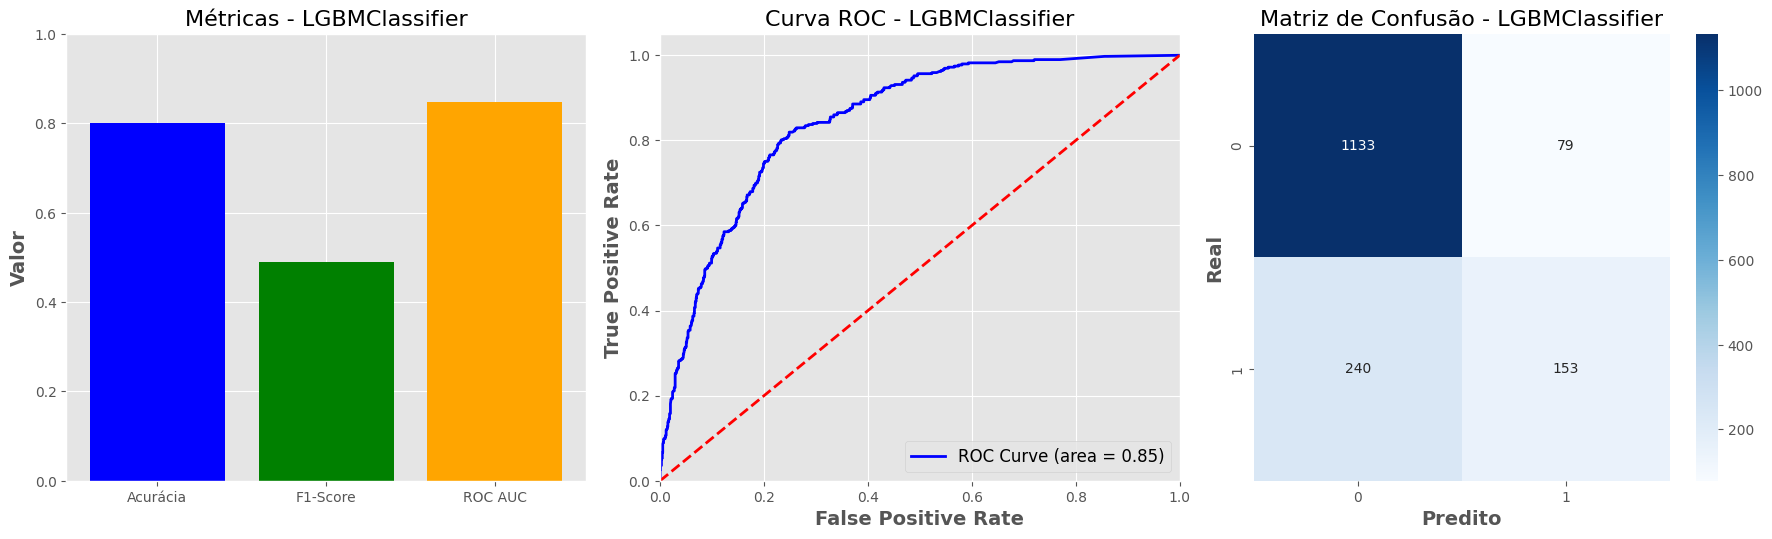

In [58]:
# Tempo de início
start_time = time.time()
# Treinando um modelo de classificação com LightGBM
param_grid = {
    'n_estimators': [100, 200],  # Número de árvores no ensemble
    'learning_rate': [0.01, 0.1],  # Taxa de aprendizado
    'max_depth': [-1, 10],  # Profundidade máxima da árvore
    'boosting_type': ['gbdt', 'dart'],  # Tipo de boosting (GBDT ou Dart)
    # 'bagging_fraction': [0.8, 1.0],  # Fração de amostras para usar em cada iteração
    # 'bagging_freq': [0, 5],  # Frequência do bagging
    # 'lambda_l1': [0, 0.1, 0.5],  # Regularização L1
    # 'lambda_l2': [0, 0.1, 0.5],  # Regularização L2
}

# Inicializar o modelo LGBMClassifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Configurar o GridSearchCV com o LGBMClassifier
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)

# Tempo de início
start_time = time.time()

# Realizar o treinamento com GridSearchCV
grid_search.fit(features_train, target_train)

# Calcular o tempo total de execução
end_time = time.time()
time_lapse = end_time - start_time

# Melhor modelo obtido
best_model = grid_search.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros encontrados: {grid_search.best_params_}")

ranking.add_model(best_model, target_test, features_test, time_lapse=time_lapse)

df_predictions['LightGBM'] = best_model.predict(df.drop('churn',axis=1))

### LogisticRegression

Tempo total de execução: 0.03 segundos
 Acurácia: 0.8074766355140187
 F1-Score: 0.5422222222222223
 ROC AUC: 0.8473387415077386
Tempo total de execução: 0.03 segundos


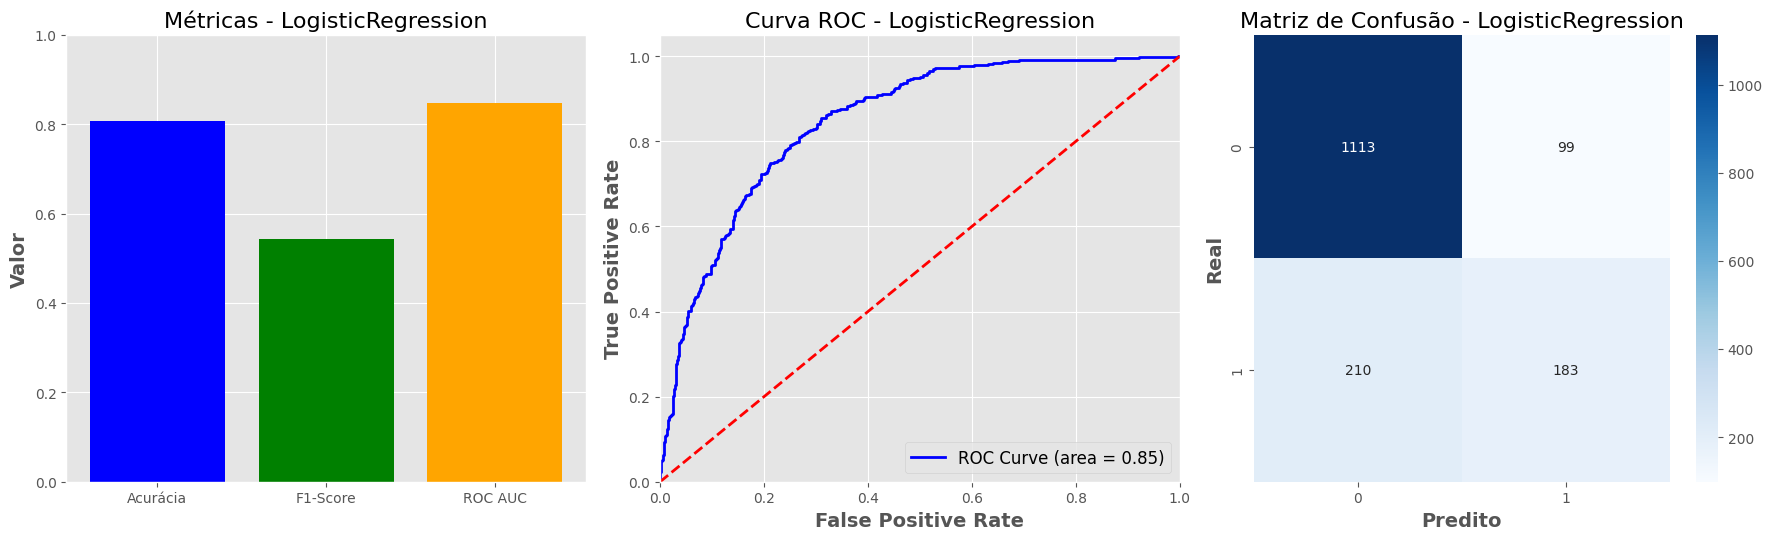

In [59]:
# Iniciar a medição do tempo
start_time = time.time()

# Definir o modelo LogisticRegression com hiperparâmetros otimizados
lr = LogisticRegression(max_iter=8000, solver='liblinear', penalty='l2', C=1.0, random_state=42)

# Treinar o modelo
try:
    lr.fit(features_train, target_train)
except Exception as e:
    print(f"Erro no treinamento: {e}")

# Avaliação do modelo
predictions = lr.predict(features_test)
proba_predictions = lr.predict_proba(features_test)[:, 1]

# Medir o tempo de execução
end_time = time.time()
time_lapse = end_time - start_time

# Exibir o tempo de execução
print(f"Tempo total de execução: {time_lapse:.2f} segundos")
# Adicionar o modelo ao ranking com as previsões e o tempo de execução
ranking.add_model(lr, target_test, features_test, time_lapse=time_lapse)

# Fazer previsões no DataFrame original (df) para a coluna 'LR'
df_predictions['LR'] = lr.predict(df.drop('churn', axis=1))

### KNN

Melhores hiperparâmetros encontrados: {'algorithm': 'auto', 'leaf_size': 2, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
Melhor ROC AUC nos dados de validação: 0.7685
 Acurácia: 0.7906542056074767
 F1-Score: 0.40425531914893614
 ROC AUC: 0.8042308047598654
Tempo total de execução: 7.13 segundos


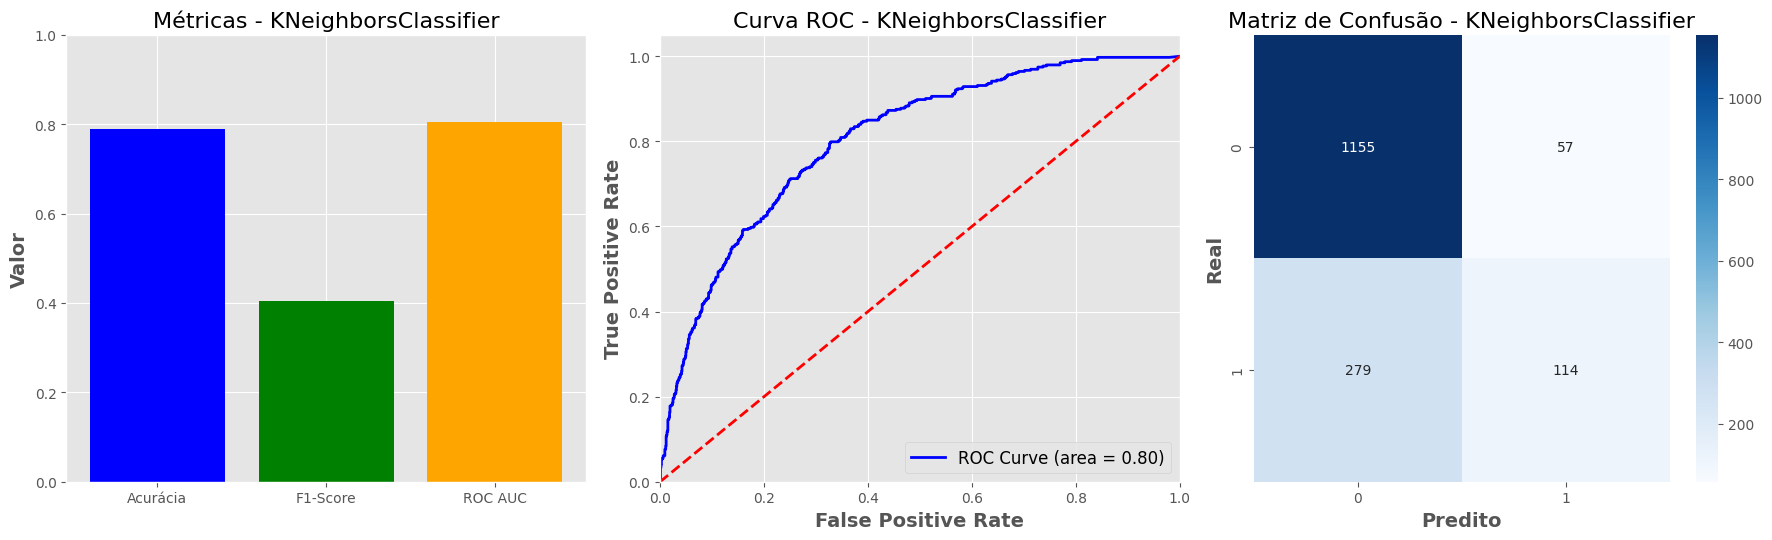

In [60]:
start_time = time.time() # Medir o tempo de início

param_grid = {
    'n_neighbors': [40,50,60],  # Número de vizinhos a serem considerados
    'weights': ['distance',],  # Ponderação dos vizinhos: 'uniform' (todos têm o mesmo peso) ou 'distance' (mais próximos têm mais peso)
    'algorithm': ['auto', 'kd_tree'],  # Algoritmo para encontrar os vizinhos
    'leaf_size': [2,4,6],  # Tamanho da folha em BallTree ou KDTree
    'p': [1, 2,4],  # Parâmetro de potência para a métrica de distância: 1 (Manhattan) ou 2 (Euclidiana)
    'metric': ['minkowski',],  # Tipo de métrica para calcular a distância
    'metric_params': [None],  # Parâmetros adicionais para a métrica, se necessário
    'n_jobs': [-1, 1],  # Número de jobs a serem rodados em paralelo (-1 para usar todos os processadores disponíveis)
}

# Inicializar o modelo KNeighborsClassifier
knn = KNeighborsClassifier()

# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='roc_auc', cv=2, n_jobs=-1, verbose=0)



# Treinar o modelo usando GridSearchCV
grid_search.fit(features_train, target_train)

# Medir o tempo de fim
end_time = time.time()
time_lapse = end_time - start_time

# Melhor modelo e parâmetros encontrados
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Melhores hiperparâmetros encontrados: {best_params}")
print(f"Melhor ROC AUC nos dados de validação: {best_score:.4f}")

# Adicionar o modelo ao ranking
ranking.add_model(best_model, target_test, features_test, time_lapse=time_lapse)

# Fazer previsões no DataFrame original (df)
df_predictions['KNN'] = best_model.predict(df.drop('churn', axis=1))

### CatBoostClassifier

 Acurácia: 0.805607476635514
 F1-Score: 0.5015974440894568
 ROC AUC: 0.8562456436483343
Tempo total de execução: 0.27 segundos


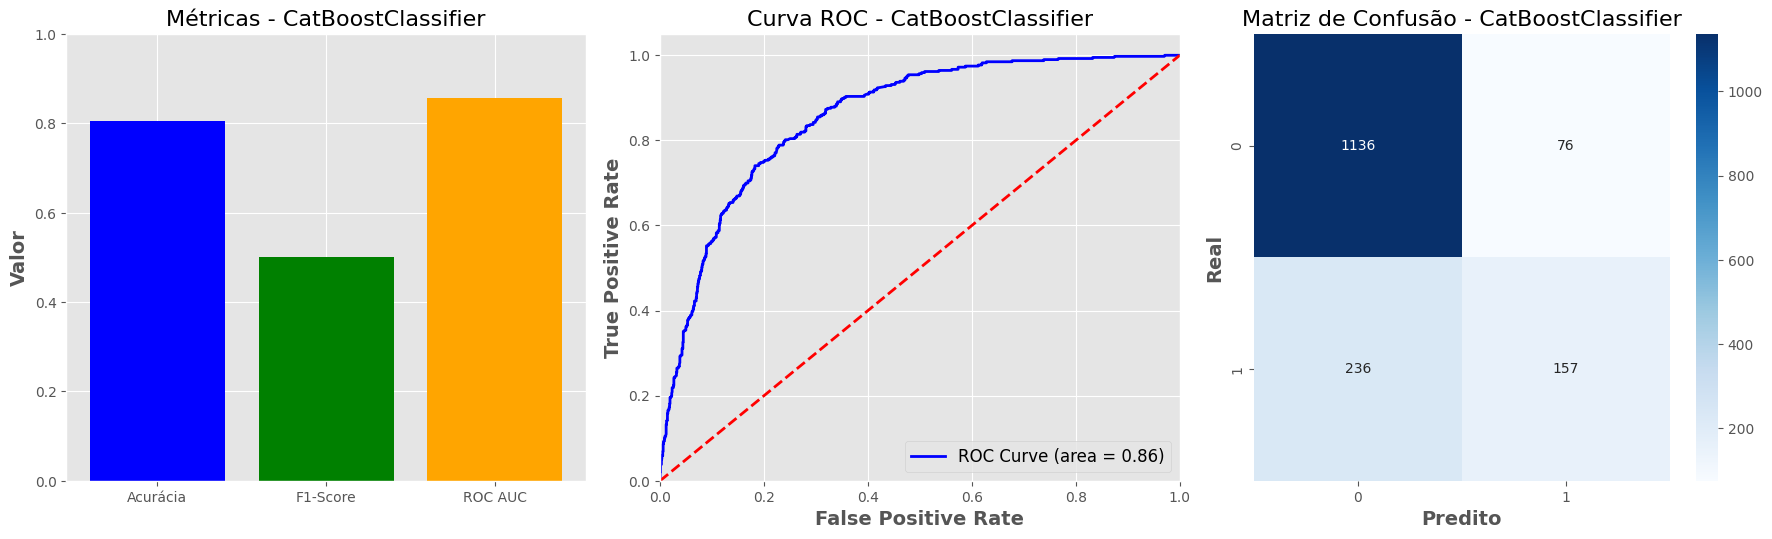

In [61]:
start_time = time.time()
# inicio e treino do modelo
catboost  = CatBoostClassifier(iterations=60, learning_rate=0.09, depth=3, verbose=0).fit(features_train, target_train)

end_time = time.time()
time_lapse = end_time - start_time
# Avaliar o modelo
ranking.add_model(catboost, target_test, features_test, time_lapse=time_lapse)
df_predictions['CBC'] = catboost.predict(df.drop('churn',axis=1))

# Resultados dos modelos

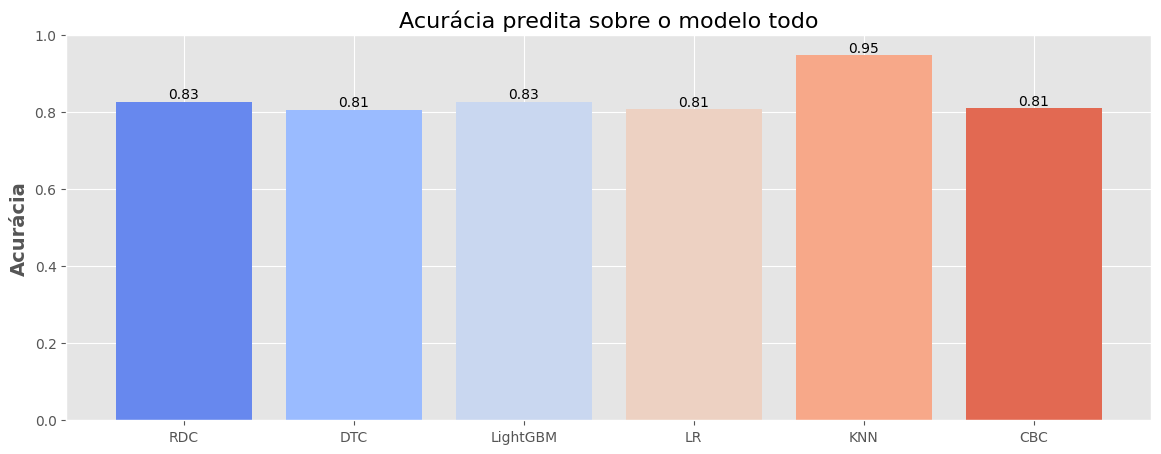

In [63]:
# Organizar os resultados em um dicionário
accuracy_dict = {}
for column in df_predictions.columns:
    if column != 'target':
        accuracy_dict[column] = (df_predictions['target'] == df_predictions[column]).mean()
        
# Plotar os valores de proximidade do target (accuracy)
plt.figure(figsize=(14, 5))
bars = plt.bar(accuracy_dict.keys(), accuracy_dict.values(), color=sns.color_palette("coolwarm", len(service_counts)))
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black')

plt.title('Acurácia predita sobre o modelo todo')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [62]:
# ranking de melhor modelo por ROC_AUC
ranking.get_ranking(sort_by="ROC_AUC")

,Acurácia,F1-Score,ROC_AUC,Tempo_de_execução
CatBoostClassifier,0.805607,0.501597,0.856246,0.268433
RandomForestClassifier,0.813707,0.529134,0.855369,23.799260
LGBMClassifier,0.801246,0.489600,0.848022,9.034508
LogisticRegression,0.807477,0.542222,0.847339,0.028000
DecisionTreeClassifier,0.792523,0.535565,0.827022,2.027999
KNeighborsClassifier,0.790654,0.404255,0.804231,7.125642


O Modelo "RandonForestClassifier" possuem os melhores resultados em ROC_AUC, F1 é alta mesmo sendo inferior a de "LogistRegression", contudo supera os demais modelos na acurácia tambem, em um teste com o dataframe completo e medindo com a previsão de cada modelo o "KNN" teve maior acertos, porem teve uma pontuação muito mais baixa contra os outros modelos